<a href="https://colab.research.google.com/github/programminghistorian/ph-submissions/blob/gh-pages/assets/clustering-visualizing-word-embeddings/clustering-visualizing-word-embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering and Visualising Documents using Word Embeddings

This can be [run in Google Colab](https://colab.research.google.com/github/jreades/ph-word-embeddings/blob/main/Clustering_Word_Embeddings.ipynb) or on your local machine. If you wish to run it locally, then you will need to ensure that you have the libraries listed in the [requirements.txt](requirements.txt) file installed *first*. THe most direct way to do this is `pip -r requirements.txt`, but I personally prefer to use Anaconda Python since it allows me to create 'virtual environments' (multiple 'versions' of Python that don't conflict with each other) as follows:

```bash
conda env create -n 'ph'
conda env activate ph
pip -r requirements.txt
jupyter lab
```

This will install the required libraries into a new virtual environment called 'ph' (Programming Historian) by first creating the environment, then activating it, installing the libraries, then launching Jupyter Lab.

<div class="alert alert-block alert-info">
    <p><b>Note</b> that we use a Parquet file for this work since it allows us to distribute a reasonably large and complex data set as a single highly-compressed file. If you would like to adapt this tutorial for use with a CSV or Excel file you have two choices: 1) simply replace <tt>df = pd.read_parquet(...)</tt> with <tt>df = pd.read_csv(...)</tt>; 2) convert your CSV/Excel file to Parquet first using <tt>pd.read_csv(...).to_parquet(...)</tt>.</p>
    <p>The other big advantage of Parquet files is that they can contain lists and dictionaries, whereas as CSV has to 'serialise' these like this: <tt>"['foo','bar',...,'baz']"</tt>. To <em>deserialise</em> a literal value like this you need to use the built-in <tt>ast</tt> library: <tt>ast.literal_eval(&lt;string_that_should_be_list&gt;)</tt>. See <a href="https://stackoverflow.com/questions/1894269/how-to-convert-string-representation-of-list-to-a-list">Stack Overflow for examples</a>.</p>
</div>

## Required Libraries

In [ ]:
%load_ext autoreload
%autoreload 1

Generally useful libraries.

In [ ]:
import pandas as pd
import numpy as np
import pickle
import math
import os
import re

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

import seaborn as sns

Needed for the dimensionality reduction stage.

In [ ]:
try:
    import umap
except ModuleNotFoundError:
    print("Module not found, will try to install...")
    !pip install umap-learn
    import umap

Needed for hierarchical clustering stage.

In [ ]:
try:
    from kneed import KneeLocator
except ModuleNotFoundError:
    print("Module not found, will try to install...")
    !pip install kneed
    from kneed import KneeLocator

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, centroid
from tabulate import tabulate

Needed for the validation and visualisation stage.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud

In [ ]:
url      = 'https://github.com/MaartenGr/cTFIDF/archive/refs/tags/v0.1.1.tar.gz'
version  = re.search(r'/v(.+?)\.tar\.gz', url).group(1)
dir_name = f'cTFIDF-{version}'
dir_path = os.path.join(os.getcwd(),dir_name)

if not os.path.exists(dir_name):

    print("Module not found, will try to download and prepare...")

    import requests, tarfile

    r = requests.get(url, allow_redirects=True)
    open(f'{dir_name}.tar.gz', 'wb').write(r.content)
    print("  Downloaded")

    tarf = tarfile.open(f'{dir_name}.tar.gz', 'r')
    for f in tarf.getnames():
        if not (f.startswith('/') or f.startswith('.')):
            tarf.extract(f)
    tarf.close()
    os.remove(f'{dir_name}.tar.gz')

    print(f"Downloaded and unpacked cTFIDF-{version}.")

import sys
if sys.path[-1] != dir_path:
    sys.path.append(dir_path)

try:
    from ctfidf import CTFIDFVectorizer
    print("Loaded Class-TF/IDF Vectorizer.")
except ModuleNotFoundError:
    print("Still can't load Class-TF/IDF Vectorizer.")

    print("="*25)
    print("You should try restarting the kernel now.\nFor some reason unpacking and loading\nimmediately doesn't work.")
    print("="*25)


Loaded Class-TF/IDF Vectorizer.


<div class="alert alert-block alert-warning">
    <b>&#9888; Stop</b>: if you <i>still</i> have errors after running the <b>above code block</b> for the first time then you will probably have to Restart the Kernel at this point. This code is trying to download a new module for which no installer exists and <i>then</i> register it with Python, but the process doesn't seem bullet-proof in my testing. Sorry, but you <i>should</i> only need to restart the Kernel this first time.
</div>

The code below tries to find a narrow sans-serif TTF font by path that is slightly nicer than the default for the WordCloud library. You would need to update this default for your own system. You can list available fonts using (/ht [imsc](https://stackoverflow.com/a/8755818/4041902)):
```python
import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
```

In [ ]:
import matplotlib.font_manager
fonts = matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
print("Possible fonts: ", end="")
for f in sorted(fonts):
    if 'Narrow' in f:
        print(f.split(os.path.sep)[-1], end=", ")
    elif 'Sans' in f:
        print(f.split(os.path.sep)[-1], end=", ")
print()

Possible fonts: RODE Noto Sans CJK SC B.otf, RODE Noto Sans CJK SC R.otf, RODE Noto Sans Hindi B.ttf, RODE Noto Sans Hindi R.ttf, Hiragino Sans GB.ttc, NotoSansArmenian.ttc, NotoSansKannada.ttc, NotoSansMyanmar.ttc, NotoSansOriya.ttc, Arial Narrow Bold Italic.ttf, Arial Narrow Bold.ttf, Arial Narrow Italic.ttf, Arial Narrow.ttf, Comic Sans MS Bold.ttf, Comic Sans MS.ttf, GillSans.ttc, Microsoft Sans Serif.ttf, NotoSansAdlam-Regular.ttf, NotoSansAvestan-Regular.ttf, NotoSansBamum-Regular.ttf, NotoSansBassaVah-Regular.ttf, NotoSansBatak-Regular.ttf, NotoSansBhaiksuki-Regular.ttf, NotoSansBrahmi-Regular.ttf, NotoSansBuginese-Regular.ttf, NotoSansBuhid-Regular.ttf, NotoSansCanadianAboriginal-Regular.otf, NotoSansCarian-Regular.ttf, NotoSansCaucasianAlbanian-Regular.ttf, NotoSansChakma-Regular.ttf, NotoSansCham-Regular.ttf, NotoSansCoptic-Regular.ttf, NotoSansCuneiform-Regular.ttf, NotoSansCypriot-Regular.ttf, NotoSansDuployan-Regular.ttf, NotoSansEgyptianHieroglyphs-Regular.ttf, NotoSansEl

In [ ]:
fp = fonts[0] # Ensure at least _something_ is set here
for f in fonts:
    if 'LiberationSansNarrow-Regular' in f:
        fp = f.split(os.path.sep)[-1].split('.')[0]
        break
    elif 'Arial Narrow.ttf' in f:
        fp = f.split(os.path.sep)[-1].split('.')[0]
        break
    elif 'Narrow' in f:
        fp = f.split(os.path.sep)[-1].split('.')[0]
print(f"Using font: {fp}")

fname = ''.join([f' {x}' if x==x.upper() else x for x in fp.split('-')[0]]).strip().replace('  ','')
print(f"  Guessing at font name: {fname}")

# These are font dictionaries for the 's'uper-title, 't'itle,
# 'a'xis, and 'l'abels.
sfont = {'fontname':fname, 'fontsize':16}
tfont = {'fontname':fname, 'fontsize':12}
afont = {'fontname':fname, 'fontsize':10}
lfont = {'fontname':fname, 'fontsize':8}

Using font: Arial Narrow
  Guessing at font name: Arial Narrow


## Configuration

In [ ]:
# Random seed
rs = 43

# Which embeddings to use
src_embeddings = 'doc_vec'

## Load the Data

In this tutorial I make use of the modern Parquet format: it's highly-compressed and columnar, so it works very well (and quickly) with large data sets. The file can also be read directly in DuckDB if you use it, but the general idea is to minimise the volume of data transfered. The columnar orientation means that you can quickly load only the columns that you need for an analysis, and don't have to read in the entire data set each time (as you would with, say, CSV or most other common data formats).

<div style="border:dotted 3px red; padding: 15px; background-color: rgb(255,225,225);">
    This cleaned file needs a permanent home that is not my personal site. BL is fine with hosting this but I've not been told to whom to provide the data. Will ask them again this week.
</div>

In [ ]:
# Name of the file
fn = 'ph-tutorial-data-cleaned.parquet'

# See if the data has already been downloaded, and
# if not, download it from the web site. We save a
# copy locally so that you can run this tutorial
# offline and also spare the host the bandwidth costs
if os.path.exists(os.path.join('data',fn)):
    df = pd.read_parquet(os.path.join('data',fn))
else:
    # We will look for/create a 'data' directory
    if not os.path.exists('data'):
        os.makedirs('data')

    # Download and save
    df = pd.read_parquet(f'http://orca.casa.ucl.ac.uk/~jreades/data/{fn}')
    df.to_parquet(os.path.join('data',fn))

In [ ]:
print(f"Loading columns: {', '.join(df.columns.tolist())}")

Loading columns: DDC, DDC_Num, Subject_Discipline, Title, Abstract, Author, Keywords, Institution, Department, EThOS_URL, ddc1, ddc2, ddc3, Decade, doc, tokens, length, word_vec, doc_vec, glove-wiki-gigaword-100


## Dimensionality Reduction

While I'm confident about the output from UMAP in a _general_ sense, I'm much less certain about the default _distance_ measure (see [sklearn docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html)). There is a distinct *possibility* that some configurations of this tutorial would obtain better results using the `cosine` metric. [This article](https://towardsdatascience.com/9-distance-measures-in-data-science-918109d069fa) appears to offer some help, but points on to a [longer discussion](https://stats.stackexchange.com/questions/99171/why-is-euclidean-distance-not-a-good-metric-in-high-dimensions) where `manhattan` is argued to be a good representation. I've rationalised my choice in the tutorial, but you should feel free to experiment!

UMAP offers a very wide range of distance metrics:

- Minkowski style metrics
  - euclidean
  - manhattan
  - chebyshev
  - minkowski
- Miscellaneous spatial metrics
  - canberra
  - braycurtis
  - haversine
- Normalized spatial metrics
  - mahalanobis
  - wminkowski
  - seuclidean
- Angular and correlation metrics
  - cosine
  - correlation

### Configuring the process

In [ ]:
dmeasure = 'euclidean'
rdims    = 4 # r-dims == Reduced dimensionality
print(f"UMAP dimensionality reduction to {rdims} dimensions with '{dmeasure}' distance measure.")

UMAP dimensionality reduction to 4 dimensions with 'euclidean' distance measure.


### Reducing dimensionality

This is where we apply the UMAP dimensionality reduction step. Expect this to take **about 45 seconds** (or **1 minute on Google Collab**).

In [ ]:
# Assumes that there is a column that contains the
# document embedding as an array/list that needs to be
# extracted to a new data frame
def x_from_df(df:pd.DataFrame, col:str='Embedding') -> pd.DataFrame:
    cols = ['E'+str(x) for x in np.arange(0,len(df[col].iloc[0]))]
    return pd.DataFrame(df[col].tolist(), columns=cols, index=df.index)

In [ ]:
%%time
X = x_from_df(df, col=src_embeddings)

reducer = umap.UMAP(
    n_neighbors=25,
    min_dist=0.01,
    n_components=rdims,
    random_state=rs)

# Basically reduces our feature vectors for each thesis, down to n dimensions
X_embedded = reducer.fit_transform(X)

CPU times: user 36.1 s, sys: 953 ms, total: 37.1 s
Wall time: 35.6 s


This next block turns the output Numpy array into a data frame with one column for each reduced dimension.

In [ ]:
embedded_dict = {}
for i in range(0,X_embedded.shape[1]):
    embedded_dict[f"Dim {i+1}"] = X_embedded[:,i] # D{dimension_num} (Dim 1...Dim n)

# dfe == df embedded
dfe = pd.DataFrame(embedded_dict, index=df.index)
del(embedded_dict)

dfe.head(3)

,Dim 1,Dim 2,Dim 3,Dim 4
EThOS_ID,,,,
233009,3.391561,3.562786,5.971835,3.534780
233034,1.274953,3.040160,2.861691,3.384511
233035,1.225121,2.281668,3.333840,3.241669


Merge the projection on to the main data frame so that we can easily explore the results.

In [ ]:
projected = df.join(dfe).sort_values(by=['ddc1','ddc2'])
print(projected.columns.values)

projected.head(3)

['DDC' 'DDC_Num' 'Subject_Discipline' 'Title' 'Abstract' 'Author'
 'Keywords' 'Institution' 'Department' 'EThOS_URL' 'ddc1' 'ddc2' 'ddc3'
 'Decade' 'doc' 'tokens' 'length' 'word_vec' 'doc_vec'
 'glove-wiki-gigaword-100' 'Dim 1' 'Dim 2' 'Dim 3' 'Dim 4']


,DDC,DDC_Num,Subject_Discipline,Title,Abstract,Author,Keywords,Institution,Department,EThOS_URL,...,doc,tokens,length,word_vec,doc_vec,glove-wiki-gigaword-100,Dim 1,Dim 2,Dim 3,Dim 4
EThOS_ID,,,,,,,,,,,,,,,,,,,,,
233034,900,900.0,History & Archaeology,The political transformation of peasant Russia...,This study gives an account of village politic...,"Figes, Orlando",Russian politics and society,University of Cambridge,None,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,...,The political transformation of peasant Russia...,"[political_transformation, peasant, russia, pe...",84,"[0.026168758, 0.14577468, -0.0757815, 0.001476...","[0.16268738, -0.0013667074, -0.2732733, 0.0075...","[0.007818172, 0.3122564, 0.12205443, 0.2344975...",1.274953,3.040160,2.861691,3.384511
233035,900,900.0,History & Archaeology,Popular culture and troop morale in the Britis...,This dissertation is based upon a study of the...,"Fuller, John Geoffrey",Morale of soldiers 1914-1918,University of Cambridge,None,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,...,Popular culture and troop morale in the Britis...,"[popular_culture, troop, morale, british, domi...",84,"[-0.0017991711, 0.12867033, -0.05608338, 0.028...","[-0.08719483, 0.01807852, 0.09975473, 0.135074...","[-0.24321905, 0.18784973, 0.12283907, 0.139223...",1.225121,2.281668,3.333840,3.241669
233036,900,900.0,History & Archaeology,Conservation and colonial expansion : a study ...,The approach adopted in this thesis is essenti...,"Grove, R.",History of ecological concern,University of Cambridge,None,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,...,Conservation and colonial expansion : a study ...,"[conservation, colonial, expansion, study, evo...",95,"[0.030833976, 0.1442279, -0.09098811, 0.012779...","[0.32978645, 0.06057465, -0.072654285, -0.0641...","[-0.16200198, 0.20134276, 0.27855596, 0.296152...",1.320103,3.419556,2.907511,3.138660


### Visualising the results

In [ ]:
# Figure for fine-tuning Matplotlib output so that
# we get nicer outputs.
def tune_figure(ax, title:str='Title'):
    ax.axis('off')
    ax.set_title(title, **tfont)
    ax.get_legend().set_title("")
    ax.get_legend().prop.set_family(lfont['fontname'])
    ax.get_legend().prop.set_size(lfont['fontsize'])
    ax.get_legend().get_frame().set_linewidth(0.0)

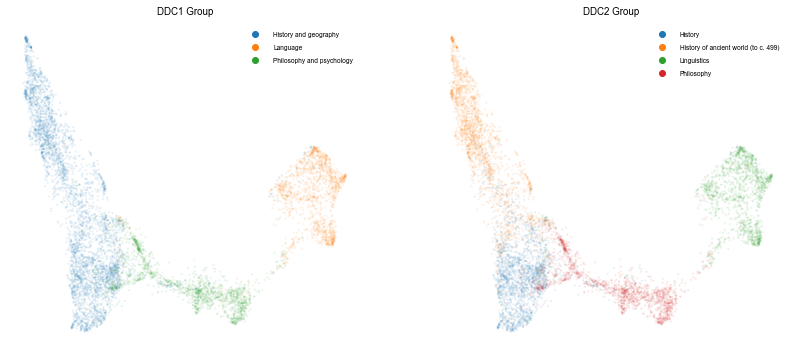

In [ ]:
f, axs = plt.subplots(1,2,figsize=(14,6))
axs = axs.flatten()

sns.scatterplot(data=projected, x='Dim 1', y='Dim 2', hue='ddc1', s=5, alpha=0.1, ax=axs[0]);
tune_figure(axs[0], 'DDC1 Group')

sns.scatterplot(data=projected, x='Dim 1', y='Dim 2', hue='ddc2', s=5, alpha=0.1, ax=axs[1]);
tune_figure(axs[1], 'DDC2 Group')

#plt.savefig('DDC_Plot.png', dpi=150)
plt.show()

## Hierarchical Clustering

Expect this next stage to take **about 4 seconds** (or **20 seconds on Google Collab**). If you consistently encounter Out-of-Memory errors in Google Colab while running this next block then you may need to sample the data instead:
```python
projected = projected.sample(frac=0.5)
```
When you perform the `join` later the unsampled records should fall out naturally though, obviously, your results will begin to differ substantially from the ones presented in the tutorial.

### Configuring the process

Note the use of `x for x in...` code to dynamically select the columns that begin with `Dim ` from the 'projected' data set. If you were to specify a different number of dimensions when doing UMAP reduction above then this code does *not* need to change since it makes no assumptions about how many dimensions will match.

In [ ]:
%%time
# Z is the full record of the clustering process
# and is what underpins the dendrogram you'll see below.
dmeasure = 'euclidean'
Z = linkage(projected[[x for x in projected.columns if x.startswith('Dim ')]],
            method='ward', metric='euclidean')

CPU times: user 1.24 s, sys: 269 ms, total: 1.51 s
Wall time: 1.87 s


Save the clustering result. Can be useful for later exploration offline.

In [ ]:
pickle.dump(Z, open(os.path.join('data','Z.pickle'), 'wb'))

### Visualising the results

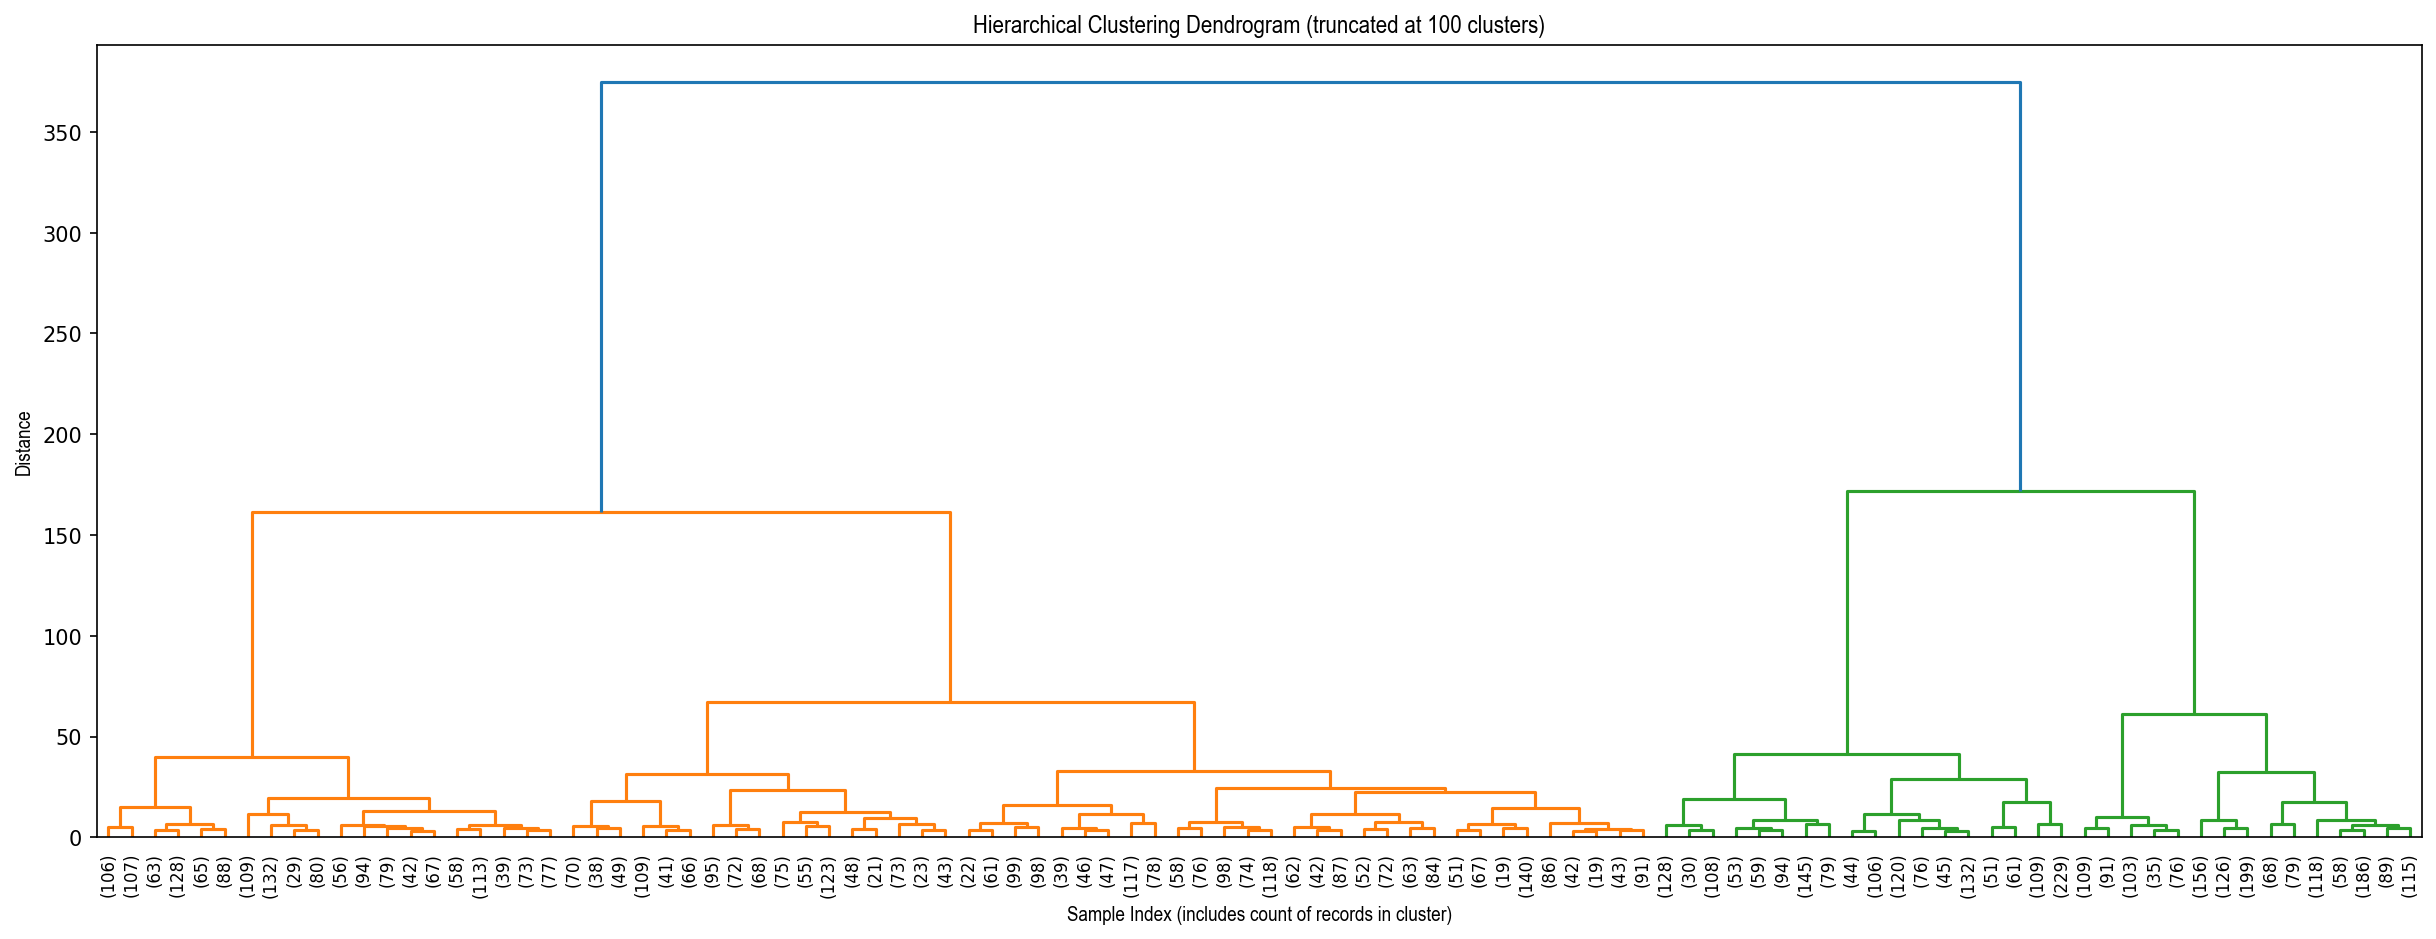

In [ ]:
last_cls = 100 # The number of last clusters to show in the dendogram

plt.title(f'Hierarchical Clustering Dendrogram (truncated at {last_cls} clusters)', **tfont)
plt.xlabel('Sample Index (includes count of records in cluster)', **afont)
plt.ylabel('Distance', **afont)
fig = plt.gcf()
fig.set_size_inches(20, 7)
fig.set_dpi(150)

dendrogram(
    Z,
    truncate_mode='lastp', # truncate dendrogram to the last p merged clusters
    p=last_cls,            # and set a value for last p merged clusters
    show_leaf_counts=True, # if parentheses then this is a count of observations, otherwise an id
    leaf_rotation=90.,
    leaf_font_size=8.,
    show_contracted=False, # to get a distribution impression in truncated branches
)
#plt.savefig(f'Dendogram-{last_cls}.png')
plt.show()

`Z` is a $(n-1)$ by 4 matrix. At the $i$-th iteration, clusters with indices $Z[i, 0]$ and $Z[i, 1]$ are combined to form cluster $n+i$. A cluster with an index less than $n$ corresponds to one of the $n$ original observations. The distance between clusters $Z[i, 0]$ and $Z[i, 1]$ is given by $Z[i, 2]$. The fourth value $Z[i, 3]$ represents the number of original observations in the newly formed cluster.

In [ ]:
table = []

# Take the 1st, the 25th, 50th and 75th 'percentiles', and the last
for i in [0, math.ceil(Z.shape[0]*0.25), math.ceil(Z.shape[0]*0.5), math.ceil(Z.shape[0]*0.75), -1]:
    r = list(Z[i])
    r.insert(0,(i if i >= 0 else len(Z)+i))
    table.append(r)
    table[-1][1] = int(table[-1][1])
    table[-1][2] = int(table[-1][2])
    table[-1][4] = int(table[-1][4])

display(
    tabulate(table,
             headers=["Iteration","$c_{i}$","$c_{j}$","$d_{ij}$","$\sum{c_{i},c_{j}}$"],
             floatfmt='0.3f', tablefmt='html'))

Iteration,$c_{i}$,$c_{j}$,$d_{ij}$,"$\sum{c_{i},c_{j}}$"
0,6667,7726,0.004,2
2001,6766,6895,0.062,2
4001,2915,4285,0.115,2
6001,9398,12718,0.232,4
8000,16000,16001,374.623,8002


### Silhouette Scoring

<div class="alert alert-block alert-warning">
    This section is <i>not</i> shown in the tutorial as it's a support to decision-making, not a core part of the tutorial.
</div>

This process is slow and computationally intensive: it is calculating a silhouette score for every clustering option between `start` and `end` to give you a sense of how the silhouette score evolves with the number of clusters. A falling silhouette score is normal since, the smaller the number of observations in the cluster, the more you're likely to see some badly-bitted observations within a cluster... at least up until the point where you start having very small clusters indeed. What we're going to be looking for is the 'knee' where this process levels out.

You're looking at **_about_ 1 minute** to repeatedly cluster the data.

In [ ]:
%%time

start_cl = 2
end_cl   = 25

sil_scores = []

print("Scoring cluster levels: ", end="")

X_embedded = projected[[x for x in projected if x.startswith('Dim ')]]

for i in range(start_cl,end_cl):
    print(".", end="")
    clusterings = fcluster(Z, i, criterion='maxclust')

    # Calculate silhouett average
    sil_avg = silhouette_score(X_embedded, clusterings)

    # Append silhouette scores
    sil_scores.append(sil_avg)

print("\nDone.")

Scoring cluster levels: .......................
Done.
CPU times: user 34.2 s, sys: 9.33 s, total: 43.6 s
Wall time: 14 s


Using the silhouette scores calculatee above we can now generate a scree plot.

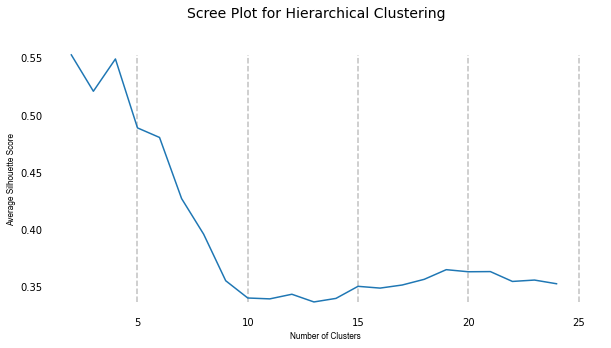

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,5));
sns.lineplot(x=np.arange(start_cl,start_cl+len(sil_scores)), y=sil_scores, ax=ax)
ax.set_title("")
ax.set_xlabel("Number of Clusters", **afont)
ax.set_ylabel("Average Silhouette Score", **afont)

plt.box(False)
plt.xticks(range(0,end_cl+1,5))
ax.tick_params(axis='both', length=0)
for xt in range(5,end_cl+1,5):
    plt.vlines(xt, np.min(sil_scores), np.max(sil_scores), colors=(0.4,0.4,0.4,0.4), linestyles='dashed')

plt.suptitle(f"Scree Plot for Hierarchical Clustering", fontsize=14);
#plt.savefig(f'Scree-plot.png', dpi=150)
plt.show();

### Knee Locator

<div class="alert alert-block alert-warning">
    This is also not shown in the tutorial as it's part of decision-making, not a core element of the tutorial.
</div>

We can eyeball the scree plot, but a good sanity-check is to use the [kneed](https://pypi.org/project/kneed/) utility to automate the process. Depending on how your clusters score this may or may not be helpful: _e.g._ sometimes a relatively small deviation triggers the 'knee' at what is obviously only a 'blip'. By experimenting with the value of `S` you can fine-tune the sensitivity to these 'blips'.

In [ ]:
kn = KneeLocator(np.arange(3,3+len(sil_scores)), sil_scores,
                 curve="convex", direction="decreasing", S=3,
                 interp_method="polynomial", polynomial_degree=4)
print(f'Suggest knee at {kn.knee} clusters.')

Suggest knee at 12 clusters.


## Validation

We're now going to investigate the clustering results in greater detail.

In [ ]:
# Assumes a data frame, a clustering result, and a DDC level (1, 2 or 3)
# for mapping the clusters on to 'plain English' labels from the DDC
def label_clusters(src_df:pd.DataFrame, clusterings:np.ndarray, ddc_level:int=1):

    # How many clusters?
    num_clusters = clusterings.max()

    # Create a new data frame holding only the
    # cluster results but indexed to the source
    tmp = pd.DataFrame({f'Cluster_{num_clusters}':clusterings}, index=src_df.index)

    # Now link them
    joined_df = src_df.join(tmp, how='inner')

    # Now get the dominant categories for each
    labels = get_dominant_cat(joined_df, clusterings.max(), ddc_level)

    # And map the labels for each cluster value
    joined_df[f'Cluster_Name_{num_clusters}'] = joined_df[f'Cluster_{num_clusters}'].apply(lambda x: labels[x])

    return joined_df

# Find the dominan class for each cluster assuming a specified DDC level (1, 2 or 3)
def get_dominant_cat(clustered_df:pd.DataFrame, num_clusters:int, ddc_level:int=1):
    labels = {}
    struct = {}

    # First, work out the dominant group in each cluster
    # and note that together with the cluster number --
    # this gives us a dict with key==dominant group and
    # then one or more cluster numbers from the output
    # above.
    for cl in range(1,num_clusters+1):

        # Identify the dominant 'domain' (i.e. group by
        # DDC description) using the value counts result.
        dom     = clustered_df[clustered_df[f'Cluster_{num_clusters}']==cl][f'ddc{ddc_level}'].value_counts().index[0]
        print(f"Cluster {cl} dominated by {dom} theses.")

        if struct.get(dom) == None:
            struct[dom] = []

        struct[dom].append(cl)

    # Next, flip this around so that we create useful
    # cluster labels for each cluster. Since we can have
    # more than one cluster dominated by the same group
    # we have to increment them (e.g. History 1, History 2)
    for g in struct.keys():
        if len(struct[g])==1:
            labels[struct[g][0]]=g
            #print(f'{g} maps to Cluster {struct[g][0]}')
        else:
            for s in range(0,len(struct[g])):
                labels[struct[g][s]]=f'{g} {s+1}'
                #print(f'{g} {s+1} maps to Cluster {struct[g][s]}')
    return labels

### 3 Clusters

Note that we 'parameterise' the settings here so that you can easily change the number of clusters and DDC level and then re-run the code. You *could* move all of the code in the following code block to a function to streamline the code further (since we re-use the code for additional clusterings) but my feeling was that in this case it would be more confusing for the reader if I did so.

In [ ]:
num_clusters = 3
ddc_level = 1

In [ ]:
# Extract clustering based on Z object
clusterings  = fcluster(Z, num_clusters, criterion='maxclust')

# Label clusters and add to df
clustered_df = label_clusters(projected, clusterings, ddc_level=ddc_level)

# Diagnostics
print()

# Classification report gives a (statistical) sense of power (TP/TN/FP/FN)
print(classification_report(
        clustered_df[f'ddc{ddc_level}'],
        clustered_df[f'Cluster_Name_{num_clusters}'],
        zero_division=0))

# A confusion matrix is basically a cross-tab (without totals, which I think are nice to add)
pd.crosstab(columns=clustered_df[f'Cluster_Name_{num_clusters}'],
            index=clustered_df[f'ddc{ddc_level}'],
            margins=True, margins_name='Total')


Cluster 1 dominated by History and geography theses.
Cluster 2 dominated by Language theses.
Cluster 3 dominated by Philosophy and psychology theses.

                           precision    recall  f1-score   support

    History and geography       0.94      0.96      0.95      4591
                 Language       0.94      0.95      0.94      1655
Philosophy and psychology       0.90      0.83      0.86      1756

                 accuracy                           0.93      8002
                macro avg       0.93      0.91      0.92      8002
             weighted avg       0.93      0.93      0.93      8002



Cluster_Name_3,History and geography,Language,Philosophy and psychology,Total
ddc1,,,,
History and geography,4423,44,124,4591
Language,58,1567,30,1655
Philosophy and psychology,244,58,1454,1756
Total,4725,1669,1608,8002


### 4 Clusters

In [ ]:
num_clusters = 4
ddc_level = 2

In [ ]:
# Extract clustering based on Z object
clusterings  = fcluster(Z, num_clusters, criterion='maxclust')

# Label clusters and add to df
clustered_df = label_clusters(projected, clusterings, ddc_level=ddc_level)

# Diagnostics
print()

# Classification report gives a (statistical) sense of power (TP/TN/FP/FN)
print(classification_report(clustered_df[f'ddc{ddc_level}'], clustered_df[f'Cluster_Name_{num_clusters}']))

# A confusion matrix is basically a cross-tab (without totals, which I think are nice to add)
pd.crosstab(columns=clustered_df[f'Cluster_Name_{num_clusters}'],
            index=clustered_df[f'ddc{ddc_level}'],
            margins=True, margins_name='Total')


Cluster 1 dominated by History of ancient world (to c. 499) theses.
Cluster 2 dominated by History theses.
Cluster 3 dominated by Linguistics theses.
Cluster 4 dominated by Philosophy theses.

                                      precision    recall  f1-score   support

                             History       0.67      0.92      0.78      2277
History of ancient world (to c. 499)       0.96      0.66      0.78      2314
                         Linguistics       0.94      0.95      0.94      1655
                          Philosophy       0.90      0.83      0.86      1756

                            accuracy                           0.83      8002
                           macro avg       0.87      0.84      0.84      8002
                        weighted avg       0.86      0.83      0.83      8002



Cluster_Name_4,History,History of ancient world (to c. 499),Linguistics,Philosophy,Total
ddc2,,,,,
History,2094,62,31,90,2277
History of ancient world (to c. 499),731,1536,13,34,2314
Linguistics,52,6,1567,30,1655
Philosophy,243,1,58,1454,1756
Total,3120,1605,1669,1608,8002


## Are the experts 'wrong'?

Here we are trying to look in more detail at the PhDs that have (potentially!) been 'misclassified' by the experts--our clustering places them in a different group from the one specified by the DDC. Clearly, we'll have some false-positives in here as well, but the point is to examine the degree to which misclassification is both plausible and useful in terms of demonstrating the value of the NLP approach.

In [ ]:
num_clusters = 4
ddc_level  = 2

In [ ]:
# Deal with long plot titles
def break_title(title:str, target_len:int=40):
    words = title.split(" ")
    fmt_title = ''
    lines     = 1
    for i in range(len(words)):
        if (len(fmt_title) + len(words[i]))/target_len > lines:
            fmt_title += "\n"
            lines += 1
        fmt_title += words[i] + " "
    return fmt_title

In [ ]:
projected = df.join(dfe).sort_values(by=['ddc1','ddc2'])

# Extract clustering based on Z object
clusterings  = fcluster(Z, num_clusters, criterion='maxclust')

# Label clusters and add to df
clustered_df = label_clusters(projected, clusterings, ddc_level=ddc_level)

Cluster 1 dominated by History of ancient world (to c. 499) theses.
Cluster 2 dominated by History theses.
Cluster 3 dominated by Linguistics theses.
Cluster 4 dominated by Philosophy theses.


This approach to misclassification works well for level 1 and level 2 of the DDC, but it gets a lot more complex when you're looking at level 3 because there are _so_ many different groups and misclassifications (e.g. Economics vs Financial Economics) that the results become much harder to interpret meaningfully. The results also end up being highly unstable at that level and you'd probably want to think about validation very differently.

Processing History DDC...
Aiming for width x height of 450 x 600
Processing History cluster (1 of 4)
Processing History of ancient world (to c. 499) cluster (2 of 4)
Processing Linguistics cluster (3 of 4)
Processing Philosophy cluster (4 of 4)
Done.
Processing History of ancient world (to c. 499) DDC...
Aiming for width x height of 450 x 600
Processing History cluster (1 of 4)
Processing History of ancient world (to c. 499) cluster (2 of 4)
Processing Linguistics cluster (3 of 4)
Processing Philosophy cluster (4 of 4)
Done.
Processing Linguistics DDC...
Aiming for width x height of 450 x 600
Processing History cluster (1 of 4)
Processing History of ancient world (to c. 499) cluster (2 of 4)
Processing Linguistics cluster (3 of 4)
Processing Philosophy cluster (4 of 4)
Done.
Processing Philosophy DDC...
Aiming for width x height of 450 x 600
Processing History cluster (1 of 4)
Processing History of ancient world (to c. 499) cluster (2 of 4)
Processing Linguistics cluster (3 of 4)
Proce

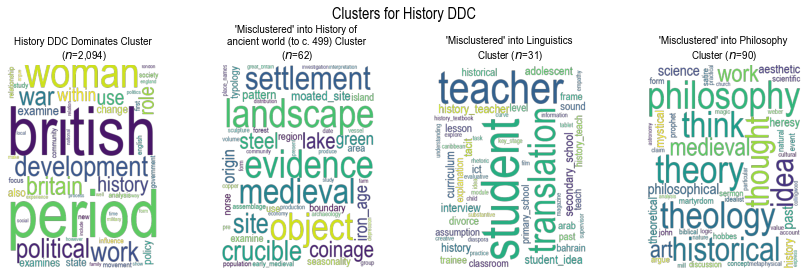

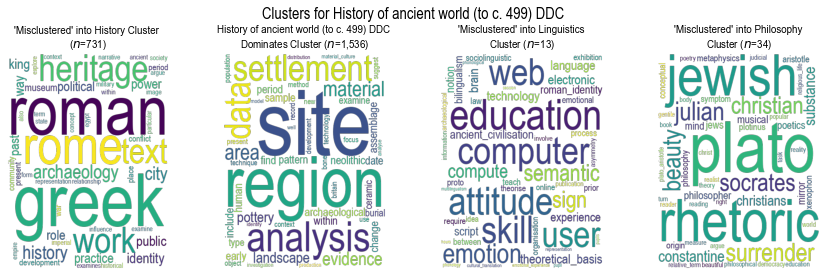

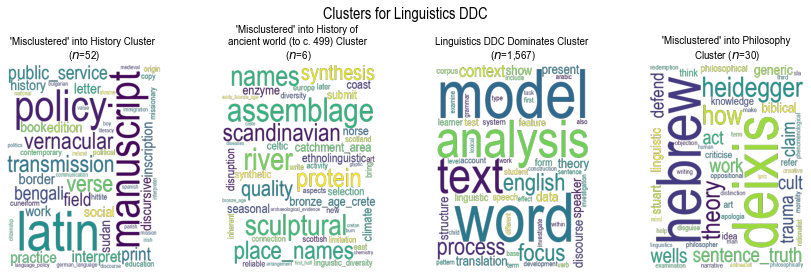

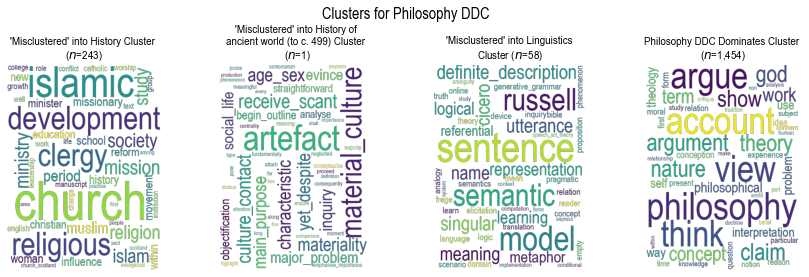

In [ ]:
fsize = (12,4)
dpi   = 150
nrows = 1

# For each of the named clusters -- these will
# have been assigned the name of the dominant
# DDC in the cluster...
for ddc_name in sorted(clustered_df[f'ddc{ddc_level}'].unique()):

    print(f"Processing {ddc_name} DDC...")

    # Here's the selected data sub-frame
    sdf = clustered_df[clustered_df[f'ddc{ddc_level}']==ddc_name]

    # Create one document per label (i.e. aggregate the individual documents and count)
    docs = pd.DataFrame({'Document': sdf.tokens.apply(' '.join), 'Class': sdf[f'Cluster_Name_{num_clusters}']})
    docs_per_class = docs.groupby(['Class'], as_index=False).agg({'Document': ' '.join})

    cvec  = CountVectorizer().fit(docs_per_class.Document)
    count = cvec.transform(docs_per_class.Document)
    words = cvec.get_feature_names_out()

    ctfidf = CTFIDFVectorizer().fit_transform(count, n_samples=len(docs))

    ncols  = len(sdf[f'Cluster_Name_{num_clusters}'].unique())
    nplots = nrows * ncols

    axwidth  = math.floor((fsize[0]/ncols)*dpi)
    axheight = math.floor(fsize[1]/nrows*dpi)

    print(f"Aiming for width x height of {axwidth} x {axheight}")

    # One image per DDC Category
    f,axes = plt.subplots(nrows, ncols, figsize=fsize)

    # Set up the word cloud
    Cloud = WordCloud(background_color=None, mode='RGBA',
                      max_words=50, relative_scaling=0.5, font_path=fp,
                      height=axheight, width=axwidth)

    for i, cl in enumerate(sorted(sdf[f'Cluster_Name_{num_clusters}'].unique())):
        print(f"Processing {cl} cluster ({i+1} of {nplots})")

        try:
            ax = axes.flatten()[i]
        except AttributeError:
            ax = axes

        tmp = pd.DataFrame({'words':words, 'weights':ctfidf.toarray()[i]}).set_index('words')

        if ddc_name == cl:
            ax.set_title(break_title(f"{ddc_name} DDC Dominates Cluster ($n$={(sdf[f'Cluster_Name_{num_clusters}']==cl).sum():,})"), **tfont)
        else:
            ax.set_title(break_title(f"'Misclustered' into {cl} Cluster ($n$={(sdf[f'Cluster_Name_{num_clusters}']==cl).sum():,})", 35), **tfont)
        ax.imshow(Cloud.generate_from_frequencies({x:tmp.loc[x].weights for x in tmp.index.tolist()}))
        ax.axis("off")
        del(tmp)

    while i < len(axes.flatten())-1:
        i += 1
        axes.flatten()[i].axis('off')

    # Set up a super-title and tweak the tight_layout
    # in line with: https://stackoverflow.com/a/45161551/4041902
    f.suptitle(f"Clusters for {ddc_name} DDC", **sfont)
    f.tight_layout(rect=[0, 0.03, 1, 0.915])

    #plt.savefig(f'c{num_clusters}-d{ddc_level}-class_tfidf-{ddc_name}.png', dpi=dpi)
    print("Done.")

### 11 Clusters

In [ ]:
num_clusters = 11
ddc_level = 3

In [ ]:
projected = df.join(dfe).sort_values(by=['ddc1','ddc2'])

# Extract clustering based on Z object
clusterings  = fcluster(Z, num_clusters, criterion='maxclust')

# Label clusters and add to df
clustered_df = label_clusters(projected, clusterings, ddc_level=ddc_level)

Cluster 1 dominated by History of ancient world to c. 499 theses.
Cluster 2 dominated by History of ancient world to c. 499 theses.
Cluster 3 dominated by History of ancient world to c. 499 theses.
Cluster 4 dominated by History, geography, and auxiliary disciplines theses.
Cluster 5 dominated by History, geography, and auxiliary disciplines theses.
Cluster 6 dominated by History, geography, and auxiliary disciplines theses.
Cluster 7 dominated by Linguistics theses.
Cluster 8 dominated by Linguistics theses.
Cluster 9 dominated by Philosophy and psychology theses.
Cluster 10 dominated by Philosophy and psychology theses.
Cluster 11 dominated by Philosophy and psychology theses.


In [ ]:
# A confusion matrix is basically a cross-tab (without totals, which I think are nice to add)
# Here we transform the matrix to have the DDCs on the top so that it's easy to scan down and
# see how they were clustered. That said, with this number of clusters and DDCs it's very hard
# to make out meaningful patterns. We've also not bothered producing the statistical tests since
# they don't map well between cluster names and DDCs.
pd.crosstab(
    columns=clustered_df[f'Cluster_Name_{num_clusters}'],
    index=clustered_df[f'ddc{ddc_level}'],
    margins=True, margins_name='Total').T

ddc3,China to 420,Dialectology and historical linguistics,Dictionaries and encyclopedias,Dictionaries of standard forms of languages,"Education, research, related topics of history","Education, research, related topics of philosophy",Egypt to 640,Etymology of standard forms of languages,Europe north and west of Italian Peninsula to c. 499,Geography and travel,...,Philosophy and psychology,Philosophy and theory of history,Phonology and phonetics of standard forms of languages,Sign languages,South Asia to 647,Standard usage (Prescriptive linguistics),Theory of philosophy,World history,Writing systems of standard forms of languages,Total
Cluster_Name_11,,,,,,,,,,,,,,,,,,,,,
History of ancient world to c. 499 1,1,0,0,0,0,0,5,0,54,0,...,0,0,0,0,2,0,0,1,0,557
History of ancient world to c. 499 2,9,0,0,0,2,0,23,0,147,0,...,1,0,0,0,4,0,0,5,1,1048
History of ancient world to c. 499 3,3,0,0,0,2,0,19,0,14,0,...,6,0,0,0,2,0,0,2,0,373
"History, geography, and auxiliary disciplines 1",1,0,0,0,17,0,16,1,13,1,...,52,0,0,0,0,1,0,22,2,696
"History, geography, and auxiliary disciplines 2",0,0,0,0,11,0,0,0,1,0,...,134,2,0,0,0,2,0,9,0,607
"History, geography, and auxiliary disciplines 3",1,0,0,0,23,0,3,0,7,10,...,51,3,0,0,0,8,0,10,1,1444
Linguistics 1,0,3,1,5,16,1,0,0,1,0,...,15,1,1,15,0,261,0,2,6,696
Linguistics 2,0,12,0,4,0,0,0,2,0,0,...,41,0,25,11,0,45,0,0,2,973
Philosophy and psychology 1,0,0,0,0,0,0,1,0,0,0,...,378,0,0,0,0,1,0,3,0,414


In [ ]:
nplots = len(clustered_df[f'Cluster_Name_{num_clusters}'].unique())
ncols  = 3
nrows  = math.ceil(nplots/ncols)
print(f"Expecting {nplots} plots on {nrows} x {ncols} layout.")

Expecting 11 plots on 4 x 3 layout.


In [ ]:
dpi      = 150
fsize    = (12,14)
axwidth  = math.floor((fsize[0]/ncols)*dpi)
axheight = math.floor(fsize[1]/nrows*dpi)

print(f"Aiming for width x height of {axwidth} x {axheight}")

Aiming for width x height of 600 x 525


In [ ]:
# Create one document per label (i.e. aggregate the individual documents and count)
docs = pd.DataFrame({'Document': clustered_df.tokens.apply(' '.join), 'Class': clustered_df[f'Cluster_Name_{num_clusters}']})
docs_per_class = docs.groupby(['Class'], as_index=False).agg({'Document': ' '.join})

cvec  = CountVectorizer().fit(docs_per_class.Document)
count = cvec.transform(docs_per_class.Document)
words = cvec.get_feature_names_out()

ctfidf = CTFIDFVectorizer().fit_transform(count, n_samples=len(docs))

Processing History of ancient world to c. 499 1 cluster (1 of 11)
Processing History of ancient world to c. 499 2 cluster (2 of 11)
Processing History of ancient world to c. 499 3 cluster (3 of 11)
Processing History, geography, and auxiliary disciplines 1 cluster (4 of 11)
Processing History, geography, and auxiliary disciplines 2 cluster (5 of 11)
Processing History, geography, and auxiliary disciplines 3 cluster (6 of 11)
Processing Linguistics 1 cluster (7 of 11)
Processing Linguistics 2 cluster (8 of 11)
Processing Philosophy and psychology 1 cluster (9 of 11)
Processing Philosophy and psychology 2 cluster (10 of 11)
Processing Philosophy and psychology 3 cluster (11 of 11)
Done.


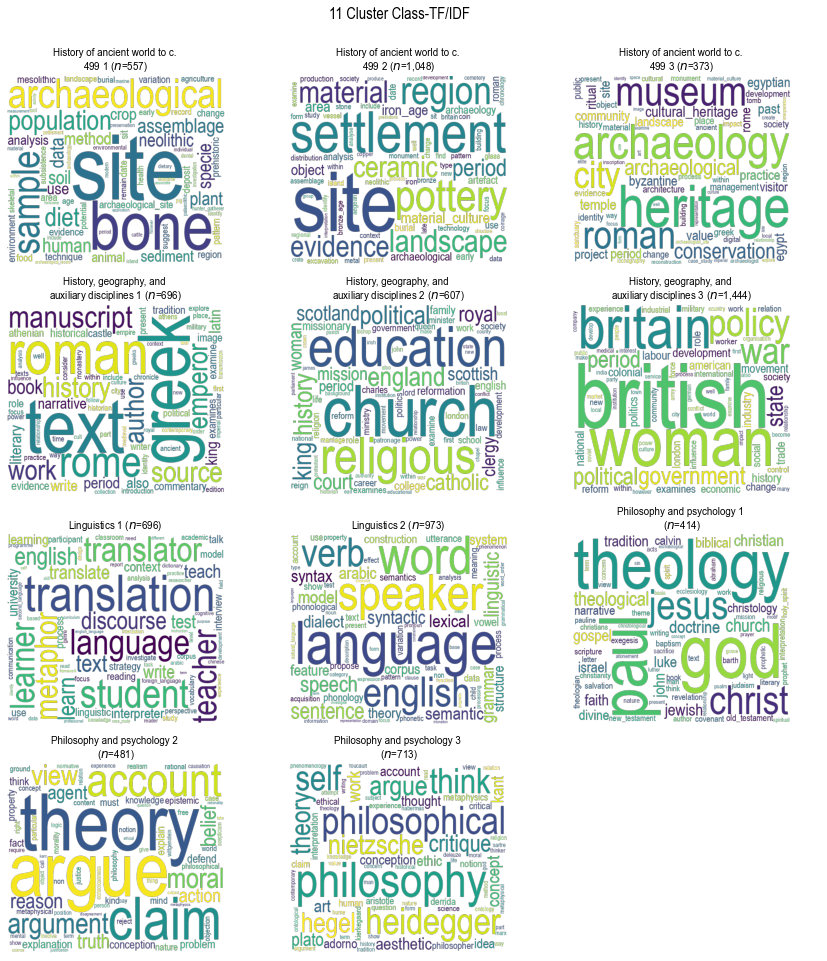

In [ ]:
# One image per DDC Category
f,axes = plt.subplots(nrows, ncols, figsize=fsize)

# Set up the word cloud
Cloud = WordCloud(background_color=None, mode='RGBA',
                  max_words=75, relative_scaling=0.5, font_path=fp,
                  height=axheight, width=axwidth)

for i, cl in enumerate(sorted(clustered_df[f'Cluster_Name_{num_clusters}'].unique())):

    print(f"Processing {cl} cluster ({i+1} of {nplots})")

    try:
        ax = axes.flatten()[i]
    except AttributeError:
        ax = axes

    tmp = pd.DataFrame({'words':words, 'weights':ctfidf.toarray()[i]}).set_index('words')

    ax.set_title(break_title(f"{cl} ($n$={(clustered_df[f'Cluster_Name_{num_clusters}']==cl).sum():,})", 30), **tfont)
    ax.imshow(Cloud.generate_from_frequencies({x:tmp.loc[x].weights for x in tmp.index.tolist()}))
    ax.axis("off")
    del(tmp)

while i < len(axes.flatten())-1:
    i += 1
    axes.flatten()[i].axis('off')

# Set up a super-title and tweak the tight_layout
# in line with: https://stackoverflow.com/a/45161551/4041902
f.suptitle(f"{num_clusters} Cluster Class-TF/IDF", **sfont)
f.tight_layout(rect=[0, 0.03, 1, 0.95])

#plt.savefig(f'c{num_clusters}-d{ddc_level}-class_tfidf.png', dpi=dpi)

print("Done.")

### Comparing clustering algorithms

In [ ]:
#dfe.head()
clustered_df.head(2)

,DDC,DDC_Num,Subject_Discipline,Title,Abstract,Author,Keywords,Institution,Department,EThOS_URL,...,length,word_vec,doc_vec,glove-wiki-gigaword-100,Dim 1,Dim 2,Dim 3,Dim 4,Cluster_11,Cluster_Name_11
EThOS_ID,,,,,,,,,,,,,,,,,,,,,
233034,900,900.0,History & Archaeology,The political transformation of peasant Russia...,This study gives an account of village politic...,"Figes, Orlando",Russian politics and society,University of Cambridge,None,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,...,84,"[0.026168758, 0.14577468, -0.0757815, 0.001476...","[0.16268738, -0.0013667074, -0.2732733, 0.0075...","[0.007818172, 0.3122564, 0.12205443, 0.2344975...",1.274953,3.040160,2.861691,3.384511,6,"History, geography, and auxiliary disciplines 3"
233035,900,900.0,History & Archaeology,Popular culture and troop morale in the Britis...,This dissertation is based upon a study of the...,"Fuller, John Geoffrey",Morale of soldiers 1914-1918,University of Cambridge,None,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,...,84,"[-0.0017991711, 0.12867033, -0.05608338, 0.028...","[-0.08719483, 0.01807852, 0.09975473, 0.135074...","[-0.24321905, 0.18784973, 0.12283907, 0.139223...",1.225121,2.281668,3.333840,3.241669,6,"History, geography, and auxiliary disciplines 3"


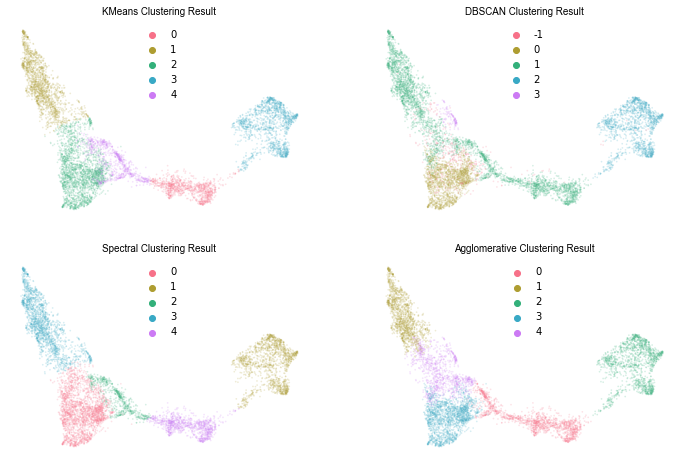

In [ ]:
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AgglomerativeClustering

clusterings = [
    KMeans(n_clusters=5, n_init=20, random_state=42),
    DBSCAN(eps=0.3, min_samples=20),
    SpectralClustering(n_clusters=5, n_init=20),
    AgglomerativeClustering(n_clusters=5, linkage='ward'),
]
ncols       = 2
nrows       = math.ceil(len(clusterings)/ncols)

dpi         = 150
fsize       = (12,8)
axwidth     = math.floor((fsize[0]/ncols)*dpi)
axheight    = math.floor(fsize[1]/nrows*dpi)

f, axs = plt.subplots(nrows,ncols,figsize=fsize)
axes   = axs.flatten()

for idx, algo in enumerate(clusterings):

    clustered_df = clustered_df[clustered_df.columns[[x.startswith('Dim') for x in clustered_df.columns]].tolist()].copy()

    rs = algo.fit(clustered_df)
    s  = pd.Series(rs.labels_, index=clustered_df.index)
    clustered_df['cluster'] = s

    sns.scatterplot(data=clustered_df, x='Dim 1', y='Dim 2', hue='cluster', palette=sns.color_palette("husl", len(s.unique())), s=3, alpha=0.2, ax=axes[idx]);
    axes[idx].axis('off')
    axes[idx].set_title(f'{algo.__class__.__name__.replace("Clustering","")} Clustering Result', **tfont)
    axes[idx].get_legend().set_title("")
    axes[idx].get_legend().get_frame().set_linewidth(0.0)
    print()

#plt.savefig(os.path.join(c.outputs_dir,f'{c.which_embedding}-{c.embedding}-d{c.dimensions}-semantic_space-clustering_comparison.png'), dpi=150)
plt.show()
#print(os.path.join(c.outputs_dir,f'{c.which_embedding}-{c.embedding}-d{c.dimensions}-semantic_space-clustering_comparison.png'))